In [1]:
%cd ..

D:\Tesis\REPO\Cloud-Classification\code


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
import os
from torchvision.io import read_image
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx

In [5]:
from src import config
from src import engine
from src import utils

Using backend: pytorch


In [6]:
from recipe.utils import *

In [7]:
import random
from random import sample
from sklearn.metrics import accuracy_score

In [8]:
torch.manual_seed(7)
np.random.seed(7)
random.seed(7)

---

In [9]:
def get_targets(paths):
        return list(map(int,list(map(int,[os.path.basename(x).split('_')[0] 
                                          for x in paths]))))

In [10]:
def sample_paths(df, n=2, col='target', random_state = 7):
    
    paths = list()
    
    for key, sub_df in df.groupby(col):
        paths+= sub_df.sample(n=n, random_state=random_state)['path'].tolist()
        
    return paths

---

# 1. Leer df train y funcion de sampleo por clase

In [11]:
paths = utils.get_gcd_paths('D:\Tesis\REPO','train')
targets = get_targets(paths)

In [12]:
df_train = pd.DataFrame({'path':paths, 'target':targets})

# 2. Inferencia en batch de test con distintos pivots

## 2.1 test_loader

In [13]:
path_test_images = utils.get_gcd_paths('D:\Tesis\REPO','test')

test_dataset = GCD(path_test_images, resize=256)

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,
        num_workers=4,
        shuffle=False,
    )

In [14]:
len(test_dataset)

9010

## 2.2 Construir grafo con imagenes pivot

In [15]:
device='cuda'

model = GraphClassifier(7).to(device)
model.load_state_dict(torch.load(f'recipe/graph_params_AUGMENTATION.pt', map_location = 'cuda'))

model.eval()

GraphClassifier(
  (cnn): CNNExtractor(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
     

In [16]:
def get_pivot_deep_features(train_paths, model, device):
    
    ## 1. train data loader
    pivot_dataset = GCD(train_paths, resize=256)
    pivot_loader = torch.utils.data.DataLoader(
            pivot_dataset,
            batch_size=32,
            num_workers=8,
            shuffle=False,
        )
    
    
    ## 2. Append deep features
    pivot_features = list()
        
    for data in pivot_loader:
        with torch.no_grad():
            deep_features = model.get_deep_features(data['images'].to(device)).cpu()
            pivot_features.append(deep_features)
        
    return torch.cat(pivot_features, dim=0)

In [17]:
pivot_paths = sample_paths(df_train, n=2)

In [18]:
pivot_features = get_pivot_deep_features(pivot_paths, model, device)

In [19]:
pivot_features.shape

torch.Size([14, 2048])

## evaluacion

In [20]:
df_results = pd.DataFrame()

for N in [2,4,8,10,15,20,40,50,100]:
    print(f'######## STARTING N = {N} ########')
    print('1. Reading pivot paths')
    pivot_paths = sample_paths(df_train, n=N, random_state=11)

    # pivot_paths = [
    #     'D:\\Tesis\\REPO\\GCD/train/1_cumulus/1_cumulus_000082.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/1_cumulus/1_cumulus_000127.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/2_altocumulus/2_altocumulus_000003.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/2_altocumulus/2_altocumulus_000028.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/3_cirrus/3_cirrus_000035.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/3_cirrus/3_cirrus_000115.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/4_clearsky/4_clearsky_000004.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/4_clearsky/4_clearsky_000055.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/5_stratocumulus/5_stratocumulus_000003.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/5_stratocumulus/5_stratocumulus_000069.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/6_cumulonimbus/6_cumulonimbus_000011.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/6_cumulonimbus/6_cumulonimbus_000059.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/7_mixed/7_mixed_000006.jpg',
    #     'D:\\Tesis\\REPO\\GCD/train/7_mixed/7_mixed_000039.jpg',
    # ]



    print('2. Calculating pivot deep features')
    pivot_features = get_pivot_deep_features(pivot_paths, model, device)

    print(f'{pivot_features.shape[0]} PIVOT IMAGES')
    
    
    test_targets = list()
    test_predictions = list()

    print('3. Calculating predictions')
    for data in tqdm(test_loader):
        pred_img = data['images']

        pred_feature = model.get_deep_features(pred_img.to(device)).cpu()

        pred_images = torch.cat([pivot_features, pred_feature], dim=0).to(device)

        with torch.no_grad():
            preds = torch.argmax(F.softmax(model.message_passing(pred_images).cpu(),dim=1), dim=1)


            test_predictions.append(preds[-1].item())
            test_targets.append(data['targets'].item())
    
    acc = accuracy_score(test_targets, test_predictions)
    
    print(f"N={N}: Test Accuracy: {acc}")
    
    df_results[f'predictions_{N}'] = test_predictions
    df_results[f'targets_{N}'] = test_targets

######## STARTING N = 2 ########
1. Reading pivot paths
2. Calculating pivot deep features
14 PIVOT IMAGES
3. Calculating predictions


100%|██████████████████████████████████████████████████████████████████████████████| 9010/9010 [04:24<00:00, 34.01it/s]


N=2: Test Accuracy: 0.7503884572697004
######## STARTING N = 4 ########
1. Reading pivot paths
2. Calculating pivot deep features
28 PIVOT IMAGES
3. Calculating predictions


100%|██████████████████████████████████████████████████████████████████████████████| 9010/9010 [04:25<00:00, 33.93it/s]


N=4: Test Accuracy: 0.7516093229744728
######## STARTING N = 8 ########
1. Reading pivot paths
2. Calculating pivot deep features
56 PIVOT IMAGES
3. Calculating predictions


100%|██████████████████████████████████████████████████████████████████████████████| 9010/9010 [04:26<00:00, 33.76it/s]


N=8: Test Accuracy: 0.7520532741398446
######## STARTING N = 10 ########
1. Reading pivot paths
2. Calculating pivot deep features
70 PIVOT IMAGES
3. Calculating predictions


100%|██████████████████████████████████████████████████████████████████████████████| 9010/9010 [04:28<00:00, 33.51it/s]


N=10: Test Accuracy: 0.7508324084350722
######## STARTING N = 15 ########
1. Reading pivot paths
2. Calculating pivot deep features
105 PIVOT IMAGES
3. Calculating predictions


100%|██████████████████████████████████████████████████████████████████████████████| 9010/9010 [04:30<00:00, 33.35it/s]


N=15: Test Accuracy: 0.7508324084350722
######## STARTING N = 20 ########
1. Reading pivot paths
2. Calculating pivot deep features
140 PIVOT IMAGES
3. Calculating predictions


100%|██████████████████████████████████████████████████████████████████████████████| 9010/9010 [04:35<00:00, 32.72it/s]


N=20: Test Accuracy: 0.7512763596004439
######## STARTING N = 40 ########
1. Reading pivot paths
2. Calculating pivot deep features
280 PIVOT IMAGES
3. Calculating predictions


100%|██████████████████████████████████████████████████████████████████████████████| 9010/9010 [04:42<00:00, 31.87it/s]


N=40: Test Accuracy: 0.751165371809101
######## STARTING N = 50 ########
1. Reading pivot paths
2. Calculating pivot deep features
350 PIVOT IMAGES
3. Calculating predictions


100%|██████████████████████████████████████████████████████████████████████████████| 9010/9010 [04:45<00:00, 31.60it/s]


N=50: Test Accuracy: 0.7530521642619312
######## STARTING N = 100 ########
1. Reading pivot paths
2. Calculating pivot deep features
700 PIVOT IMAGES
3. Calculating predictions


100%|██████████████████████████████████████████████████████████████████████████████| 9010/9010 [05:04<00:00, 29.61it/s]

N=100: Test Accuracy: 0.7509433962264151


In [21]:
df_results.to_csv('inference experiments/df_results_s11.csv', index=False)

In [30]:
from sklearn.metrics import accuracy_score

In [33]:
accuracy_score(test_targets, test_predictions)

0.7485016648168702

In [34]:
r = np.array(test_targets)[(np.array(test_targets) == np.array(test_predictions))]

In [35]:
pd.Series(r).value_counts()/pd.Series(np.array(test_targets)).value_counts()

0    0.693333
1    0.457333
2    0.868526
3    0.984267
4    0.658101
5    0.810177
6    0.395387
dtype: float64

---

# Curva de accuracy por numero de imagenes pivot por clase

In [13]:
%ls

 Volume in drive D is SSD
 Volume Serial Number is 6C2D-D248

 Directory of D:\Tesis\REPO\Cloud-Classification\code

05/02/2022  11:47 AM    <DIR>          .
05/02/2022  11:47 AM    <DIR>          ..
04/28/2022  11:37 PM    <DIR>          .ipynb_checkpoints
04/29/2022  12:24 AM    <DIR>          data preprocessing
04/28/2022  08:49 PM    <DIR>          images
05/02/2022  11:50 AM    <DIR>          inference experiments
04/30/2022  01:51 PM    <DIR>          notebooks
04/30/2022  02:30 PM    <DIR>          recipe
04/28/2022  08:49 PM    <DIR>          src
               0 File(s)              0 bytes
               9 Dir(s)  329,346,191,360 bytes free


In [22]:
df_result = pd.read_csv('inference experiments/df_results_s11.csv')

In [23]:
accuracy_score

<function sklearn.metrics._classification.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)>

In [24]:
results = dict()

for N in [2,4,8,10,15,20,40,50,100]:
    
    results[N] = accuracy_score(df_result[f"targets_{N}"], df_result[f"predictions_{N}"])
    
results_data = pd.Series(results)*100

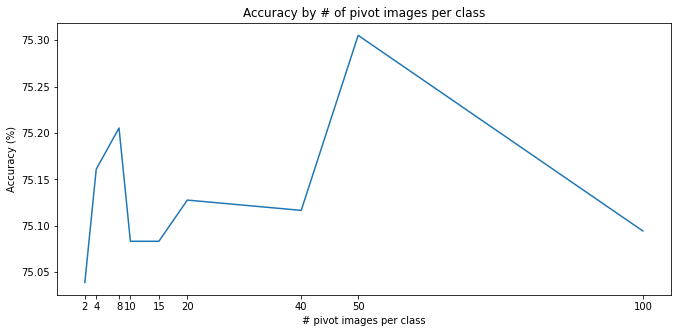

In [25]:
plt.figure(figsize=(11,5))
results_data.plot.line()
plt.xticks(results_data.index.values)
plt.title('Accuracy by # of pivot images per class')
plt.ylabel('Accuracy (%)')
plt.xlabel('# pivot images per class')
plt.show()

---

In [103]:
def get_targets_wname(paths):
        return list(map(str,list(map(str,["_".join(os.path.basename(x).split('_')[:-1]) 
                                          for x in paths]))))

In [104]:
pivot_paths = sample_paths(df_train, n=4, random_state=10)
pivot_targets = get_targets_wname(pivot_paths)

#### read pivot images

In [106]:
images = []

for p in pivot_paths:
    img = read_image(p).int().numpy().transpose(1,2,0)
    images.append(img)

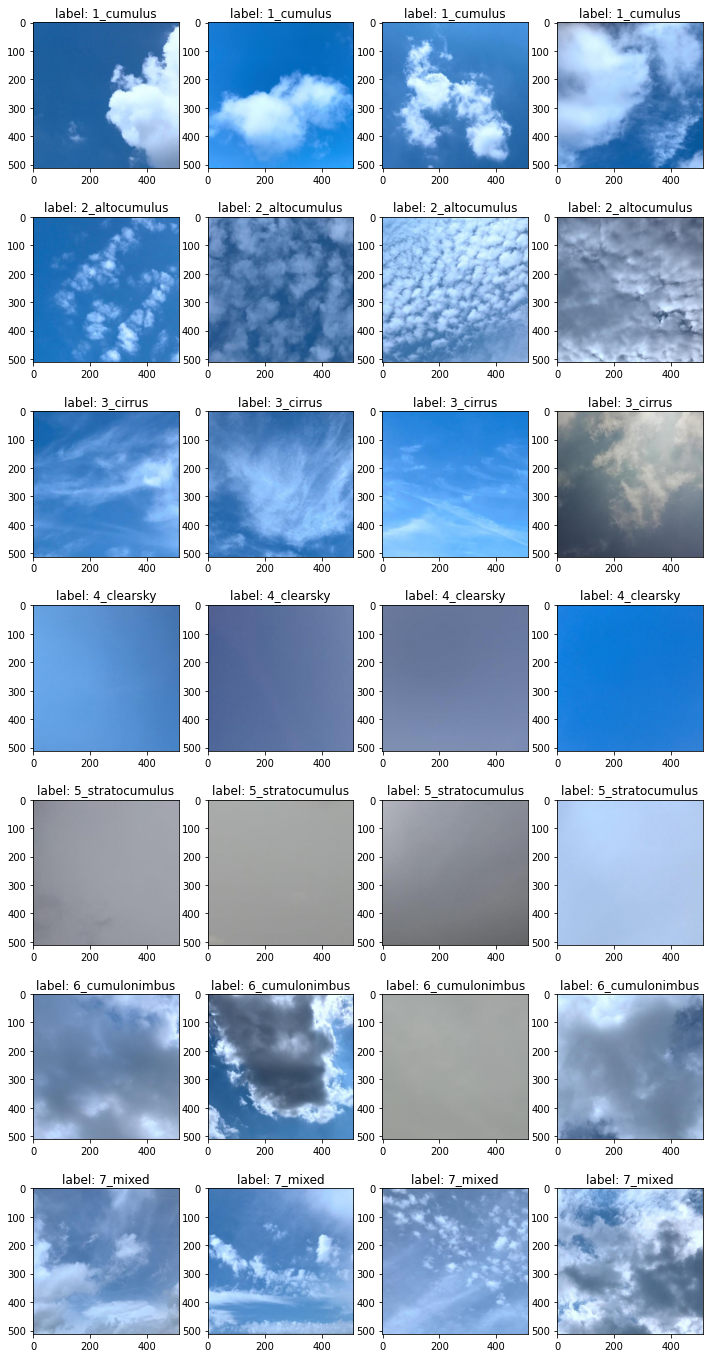

In [111]:
fig = plt.figure(figsize=(12, 28))
columns = 4
rows = 8
for i in range(1, 4*7 +1):
    img = images[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(f'label: {pivot_targets[i-1]}')
plt.savefig('inference experiments/best_pivot_images.png')
plt.show()